In [1]:
import os
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import StorageLevel, SparkConf, SparkContext
import sparknlp

print(_find_spark_home())

C:\Users\kasse\anaconda3\envs\bigData\Lib\site-packages\pyspark


In [2]:
# conf = (
#     SparkConf()
#     .setMaster("local[*]")
#     .set("spark.local.dir", "/home/zzfz/spark-temp")
#     .set("spark.driver.memory", "6g")
#     .set("spark.executor.memory", "12g")
#     .set("spark.driver.maxResultSize", "10g")
#     .set("spark.pyspark.python", "/home/zzfz/anaconda3/envs/BigData/bin/python")
#     .set("spark.pyspark.driver.python", "/home/zzfz/anaconda3/envs/BigData/bin/python")
# )

# spark = (
#     SparkSession.builder.appName("PySpark Hadoop Integration")
#     .config(conf=conf)
#     .getOrCreate()
# )

spark = sparknlp.start()

sc = spark.sparkContext

for item in sc.getConf().getAll():
    print(item)

('spark.driver.memory', '16G')
('spark.submit.pyFiles', 'C:/Users/kasse/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-5.2.2.jar,C:/Users/kasse/.ivy2/jars/com.typesafe_config-1.4.2.jar,C:/Users/kasse/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,C:/Users/kasse/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.12.500.jar,C:/Users/kasse/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,C:/Users/kasse/.ivy2/jars/com.google.cloud_google-cloud-storage-2.20.1.jar,C:/Users/kasse/.ivy2/jars/com.navigamez_greex-1.0.jar,C:/Users/kasse/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,C:/Users/kasse/.ivy2/jars/com.microsoft.onnxruntime_onnxruntime-1.16.3.jar,C:/Users/kasse/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,C:/Users/kasse/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,C:/Users/kasse/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,C:/Users/kasse/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,C:/Users/kasse/.ivy2/jars/com.google.guava_listenablefuture-9999.0-emp

In [3]:
df = (
    spark.read.option("delimiter", "\t")
    .option("header", "true")
    .csv("hdfs://localhost:9000/datasets/Amazon_Reviews/*.tsv")
)

df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   53096384| R63J84G1LOX6R|1563890119|     763187671|The Sandman Vol. ...|           Books|          4|            0|          1|   N|                N|ignore the review...|this is the first...| 1995-08-13|
|         US|   53096399|R1BALOA11Z06MT|1559947608|     381720534|The 22 Immutable ...|           Books|          4|    

In [4]:
from pyspark.sql.functions import col, count, when

# Calculate the total number of rows
total_rows = df.count()

# Calculate the ratio of nulls for each column
null_rows = df.select([(count(when(col(c).isNull(), c))).alias(c) for c in df.columns])

# Show the null ratios
null_rows.show()

+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+
|marketplace|customer_id|review_id|product_id|product_parent|product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|review_body|review_date|
+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+
|          0|          0|        0|         0|             0|            0|            1753|       1787|         1794|       1794|1794|             1794|           2044|      12438|       8243|
+-----------+-----------+---------+----------+--------------+-------------+----------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+



In [5]:
# Data Cleaning
df = df.na.drop()

In [6]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# Convert columns to integer
df = df.withColumn("star_rating", col("star_rating").cast(IntegerType()))
df = df.withColumn("helpful_votes", col("helpful_votes").cast(IntegerType()))
df = df.withColumn("total_votes", col("total_votes").cast(IntegerType()))

# Convert 'Y'/'N' to True/False for verified_purchase
df = df.withColumn(
    "verified_purchase", when(col("verified_purchase") == "Y", True).otherwise(False)
)

# Convert 'Y'/'N' to True/False for vine
df = df.withColumn("vine", when(col("vine") == "Y", True).otherwise(False))

In [7]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: boolean (nullable = false)
 |-- verified_purchase: boolean (nullable = false)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [8]:
# df.describe().show()

In [9]:
sampled_df = df.sample(fraction=0.00001, seed=3)

sampled_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+-----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes| vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+-----+-----------------+--------------------+--------------------+-----------+
|         US|   50610322|R38YNIXCN4NILA|B00003CXDU|     472494397|  Galaxy Quest [VHS]|               Video|          5|          220|        226|false|            false|    Stunning parody.|Those are the bes...| 2000-05-20|
|         US|   48062231| RCALV2V82C9TF|B00004Z511|     678427290|Kid A (Limited Ed...|             

In [10]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, UniversalSentenceEncoder, SentimentDLModel
from pyspark.ml import Pipeline


def create_sentiment_pipeline(input_col):
    # Assemble Document
    documentAssembler = (
        DocumentAssembler().setInputCol(input_col).setOutputCol("document")
    )

    # Tokenize the document
    tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

    # Use Universal Sentence Encoder for embeddings
    embeddings = (
        UniversalSentenceEncoder.pretrained()
        .setInputCols(["document"])
        .setOutputCol("sentence_embeddings")
    )

    # Load the pre-trained sentiment analysis model
    sentimentModel = (
        SentimentDLModel.pretrained("sentimentdl_use_twitter", "en")
        .setInputCols(["sentence_embeddings"])
        .setOutputCol("sentiment")
    )

    # Define the pipeline
    pipeline = Pipeline(
        stages=[documentAssembler, tokenizer, embeddings, sentimentModel]
    )

    return pipeline


# Create pipelines for review_headline and review_body
pipeline_headline = create_sentiment_pipeline("review_headline")
pipeline_body = create_sentiment_pipeline("review_body")

# # Fit and transform the pipelines
pipeline_model_headline = pipeline_headline.fit(sampled_df)
result_headline = pipeline_model_headline.transform(sampled_df)

pipeline_model_body = pipeline_body.fit(sampled_df)
result_body = pipeline_model_body.transform(sampled_df)

# Fit and transform the pipelines
# pipeline_model_headline = pipeline_headline.fit(df)
# result_headline = pipeline_model_headline.transform(df)

# pipeline_model_body = pipeline_body.fit(df)
# result_body = pipeline_model_body.transform(df)

# Display results
result_headline.select("review_headline", "sentiment.result").show(truncate=False)
result_body.select("review_body", "sentiment.result").show(truncate=False)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]
+---------------------------------+----------+
|review_headline                  |result    |
+---------------------------------+----------+
|Stunning parody.                 |[positive]|
|is this happening                |[negative]|
|High-Larious!                    |[neutral] |
|It´s like reading the comic!     |[positive]|
|A heart-shaped French delicacy!!!|[positive]|
|Worth the cash...                |[positive]|
|GnR Greatest Hits                |[positive]|
|Peachy Keane                     |[negative]|
|The debut that started it all!   |[positive]|
|Stripes                  

In [11]:
# Extract the 'result' column and rename it for clarity
result_headline = result_headline.select(
    "review_id", col("sentiment.result").alias("headline_sentiment")
)
result_body = result_body.select(
    "review_id", col("sentiment.result").alias("body_sentiment")
)

# Flatten the 'result' column as it's typically a list
result_headline = result_headline.withColumn(
    "headline_sentiment", col("headline_sentiment").getItem(0)
)
result_body = result_body.withColumn("body_sentiment", col("body_sentiment").getItem(0))

# Join the sentiment results back to the original DataFrame
sampled_df = sampled_df.join(result_headline, "review_id").join(
    result_body, "review_id"
)
# df = df.join(result_headline, "review_id").join(result_body, "review_id")

In [12]:
sampled_df.show()

+--------------+-----------+-----------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+-----+-----------------+--------------------+--------------------+-----------+------------------+--------------+
|     review_id|marketplace|customer_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes| vine|verified_purchase|     review_headline|         review_body|review_date|headline_sentiment|body_sentiment|
+--------------+-----------+-----------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+-----+-----------------+--------------------+--------------------+-----------+------------------+--------------+
|R38YNIXCN4NILA|         US|   50610322|B00003CXDU|     472494397|  Galaxy Quest [VHS]|               Video|          5|          220|        226|false|            false|    Stunning parody.|Those are the bes...| 2000-05-20

In [13]:
# Distribution of body_sentiment
body_sentiment_distribution = sampled_df.groupBy("body_sentiment").count()
body_sentiment_distribution.show()

# Distribution of headline_sentiment
headline_sentiment_distribution = sampled_df.groupBy("headline_sentiment").count()
headline_sentiment_distribution.show()

+--------------+-----+
|body_sentiment|count|
+--------------+-----+
|      positive|  653|
|      negative|  412|
|       neutral|   41|
+--------------+-----+

+------------------+-----+
|headline_sentiment|count|
+------------------+-----+
|          positive|  851|
|          negative|  213|
|           neutral|   42|
+------------------+-----+



In [14]:
from pyspark.sql import functions as F

# Group by product_category and body_sentiment, then count the occurrences
distribution = sampled_df.groupBy("product_category", "body_sentiment").count()

# Order the results for better readability (optional)
distribution = distribution.orderBy("product_category", "body_sentiment")

# Show the results
distribution.show(distribution.count(), truncate=False)

+----------------------+--------------+-----+
|product_category      |body_sentiment|count|
+----------------------+--------------+-----+
|Apparel               |negative      |22   |
|Apparel               |neutral       |3    |
|Apparel               |positive      |41   |
|Automotive            |negative      |19   |
|Automotive            |positive      |15   |
|Baby                  |negative      |4    |
|Baby                  |positive      |11   |
|Beauty                |negative      |24   |
|Beauty                |neutral       |2    |
|Beauty                |positive      |24   |
|Books                 |negative      |13   |
|Books                 |neutral       |2    |
|Books                 |positive      |23   |
|Camera                |negative      |8    |
|Camera                |positive      |8    |
|Digital_Ebook_Purchase|negative      |17   |
|Digital_Ebook_Purchase|positive      |47   |
|Digital_Music_Purchase|negative      |2    |
|Digital_Music_Purchase|neutral   

In [15]:
from pyspark.sql import functions as F

# Group by product_category and body_sentiment, then count the occurrences
distribution = sampled_df.groupBy("product_category", "headline_sentiment").count()

# Order the results for better readability (optional)
distribution = distribution.orderBy("product_category", "headline_sentiment")

# Show the results
distribution.show(distribution.count(), truncate=False)

+----------------------+------------------+-----+
|product_category      |headline_sentiment|count|
+----------------------+------------------+-----+
|Apparel               |negative          |10   |
|Apparel               |positive          |56   |
|Automotive            |negative          |8    |
|Automotive            |neutral           |4    |
|Automotive            |positive          |22   |
|Baby                  |positive          |15   |
|Beauty                |negative          |12   |
|Beauty                |neutral           |3    |
|Beauty                |positive          |35   |
|Books                 |negative          |5    |
|Books                 |neutral           |2    |
|Books                 |positive          |31   |
|Camera                |negative          |5    |
|Camera                |positive          |11   |
|Digital_Ebook_Purchase|negative          |8    |
|Digital_Ebook_Purchase|positive          |56   |
|Digital_Music_Purchase|negative          |2    |


In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType


def sentiment_to_number(sentiment):
    return {"positive": 1, "negative": -1, "neutral": 0}.get(sentiment, 0)


sentiment_udf = udf(sentiment_to_number, IntegerType())

# Apply the UDF to the sentiment columns
sampled_df = sampled_df.withColumn(
    "num_headline_sentiment", sentiment_udf("headline_sentiment")
)
sampled_df = sampled_df.withColumn(
    "num_body_sentiment", sentiment_udf("body_sentiment")
)
sampled_df.show()

# # Apply the UDF to the sentiment columns
# df = df.withColumn("num_headline_sentiment", sentiment_udf("headline_sentiment"))
# df = df.withColumn("num_body_sentiment", sentiment_udf("body_sentiment"))
# df.show()

+--------------+-----------+-----------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+-----+-----------------+--------------------+--------------------+-----------+------------------+--------------+----------------------+------------------+
|     review_id|marketplace|customer_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes| vine|verified_purchase|     review_headline|         review_body|review_date|headline_sentiment|body_sentiment|num_headline_sentiment|num_body_sentiment|
+--------------+-----------+-----------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+-----+-----------------+--------------------+--------------------+-----------+------------------+--------------+----------------------+------------------+
|R38YNIXCN4NILA|         US|   50610322|B00003CXDU|     472494397|  Galaxy Quest [VHS]|          

In [17]:
from pyspark.sql import functions as F


sampled_df = sampled_df.withColumn(
    "star_rating", sampled_df["star_rating"].cast("float")
)
sampled_df = sampled_df.withColumn(
    "num_headline_sentiment", sampled_df["num_headline_sentiment"].cast("float")
)
sampled_df = sampled_df.withColumn(
    "num_body_sentiment", sampled_df["num_body_sentiment"].cast("float")
)

category_stats = sampled_df.groupBy("product_category").agg(
    F.mean("star_rating").alias("mean_star_rating"),
    F.expr("percentile_approx(star_rating, 0.5)").alias(
        "median_star_rating"
    ),  # Approximate median
    F.mean("num_headline_sentiment").alias("mean_headline_sentiment"),
    F.mean("num_body_sentiment").alias("mean_body_sentiment"),
)


# df = df.withColumn("star_rating", df["star_rating"].cast("float"))
# df = df.withColumn("num_headline_sentiment", df["num_headline_sentiment"].cast("float"))
# df = df.withColumn("num_body_sentiment", df["num_body_sentiment"].cast("float"))

# category_stats = df.groupBy("product_category").agg(
#     F.mean("star_rating").alias("mean_star_rating"),
#     F.expr("percentile_approx(star_rating, 0.5)").alias(
#         "median_star_rating"
#     ),  # Approximate median
#     F.mean("num_headline_sentiment").alias("mean_headline_sentiment"),
#     F.mean("num_body_sentiment").alias("mean_body_sentiment"),
# )
category_stats.show(category_stats.count(), truncate=False)

+----------------------+------------------+------------------+-----------------------+--------------------+
|product_category      |mean_star_rating  |median_star_rating|mean_headline_sentiment|mean_body_sentiment |
+----------------------+------------------+------------------+-----------------------+--------------------+
|Video                 |4.166666666666667 |5.0               |0.6666666666666666     |0.6666666666666666  |
|Music                 |4.52542372881356  |5.0               |0.3559322033898305     |0.5254237288135594  |
|Video DVD             |4.660377358490566 |5.0               |0.7924528301886793     |0.3584905660377358  |
|Mobile_Apps           |3.963636363636364 |5.0               |0.7636363636363637     |0.38181818181818183 |
|Books                 |4.342105263157895 |5.0               |0.6842105263157895     |0.2631578947368421  |
|Digital_Video_Download|4.36734693877551  |5.0               |0.8367346938775511     |0.5102040816326531  |
|Digital_Ebook_Purchase|4.40

In [18]:
from pyspark.sql.functions import col

# # Ensure the columns are cast to float for division
# df = df.withColumn("helpful_votes", col("helpful_votes").cast("float"))
# df = df.withColumn("total_votes", col("total_votes").cast("float"))

# # Calculate the ratio
# df = df.withColumn("helpful_ratio", col("helpful_votes") / col("total_votes"))

# Ensure the columns are cast to float for division
sampled_df = sampled_df.withColumn("helpful_votes", col("helpful_votes").cast("float"))
sampled_df = sampled_df.withColumn("total_votes", col("total_votes").cast("float"))

# Calculate the ratio
sampled_df = sampled_df.withColumn(
    "helpful_ratio", col("helpful_votes") / col("total_votes")
)

sampled_df.show()

+--------------+-----------+-----------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+-----+-----------------+--------------------+--------------------+-----------+------------------+--------------+----------------------+------------------+------------------+
|     review_id|marketplace|customer_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes| vine|verified_purchase|     review_headline|         review_body|review_date|headline_sentiment|body_sentiment|num_headline_sentiment|num_body_sentiment|     helpful_ratio|
+--------------+-----------+-----------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+-----+-----------------+--------------------+--------------------+-----------+------------------+--------------+----------------------+------------------+------------------+
|R38YNIXCN4NILA|         US|   50610322|

In [19]:
from pyspark.sql import functions as F

helpful_ratio = sampled_df.groupBy("product_category").agg(
    F.mean("helpful_ratio").alias("mean_helpful_ratio"),
    F.expr("percentile_approx(helpful_ratio, 0.5)").alias("median_helpful_ratio"),
)
helpful_ratio.show()

+--------------------+------------------+--------------------+
|    product_category|mean_helpful_ratio|median_helpful_ratio|
+--------------------+------------------+--------------------+
|               Video|0.4078171091445428|                0.25|
|               Music|0.8117432029018842|                 1.0|
|           Video DVD|0.5773290069165743|  0.6666666666666666|
|         Mobile_Apps|0.6778471259053784|  0.8770226537216829|
|               Books|0.6395135401113402|                0.75|
|Digital_Video_Dow...|0.4011111111111111|                0.25|
|Digital_Ebook_Pur...| 0.713409586056645|  0.7777777777777778|
|                Toys|0.6972222222222223|                 0.8|
|         Electronics|0.7964912280701754|                 1.0|
|             Apparel|0.6029411764705882|                 1.0|
|          Automotive|0.7344444444444443|                 1.0|
|                Baby|0.7676767676767676|  0.6666666666666666|
|              Beauty|0.6996643356643356|              

In [20]:
sampled_df.cache()

DataFrame[review_id: string, marketplace: string, customer_id: string, product_id: string, product_parent: string, product_title: string, product_category: string, star_rating: float, helpful_votes: float, total_votes: float, vine: boolean, verified_purchase: boolean, review_headline: string, review_body: string, review_date: string, headline_sentiment: string, body_sentiment: string, num_headline_sentiment: float, num_body_sentiment: float, helpful_ratio: double]

In [21]:
from pyspark.sql.functions import when

# Avoid division by zero and create a new column for the ratio
sampled_df = sampled_df.withColumn(
    "helpful_ratio",
    when(col("total_votes") != 0, col("helpful_votes") / col("total_votes")).otherwise(
        0
    ),
)

# Calculate correlation between star_rating and helpful_ratio
star_helpful_ratio_corr = sampled_df.stat.corr("star_rating", "helpful_ratio")
print(
    "Correlation between star_rating and helpful_votes/total_votes ratio:",
    star_helpful_ratio_corr,
)
# Calculate correlation between star_rating and helpful_votes
star_helpful_corr = sampled_df.stat.corr("star_rating", "helpful_votes")
print("Correlation between star_rating and helpful_votes:", star_helpful_corr)

# Calculate correlation between star_rating and total_votes
star_total_corr = sampled_df.stat.corr("star_rating", "total_votes")
print("Correlation between star_rating and total_votes:", star_total_corr)


# Avoid division by zero and create a new column for the ratio
sampled_df = sampled_df.withColumn(
    "helpful_ratio",
    when(col("total_votes") != 0, col("helpful_votes") / col("total_votes")).otherwise(
        0
    ),
)

# Calculate correlation between star_rating and helpful_ratio
star_helpful_ratio_corr = sampled_df.stat.corr("star_rating", "helpful_ratio")
print(
    "Correlation between star_rating and helpful_votes/total_votes ratio:",
    star_helpful_ratio_corr,
)

Correlation between star_rating and helpful_votes/total_votes ratio: -0.06146445365858801
Correlation between star_rating and helpful_votes: 0.001321346026123981
Correlation between star_rating and total_votes: -0.05329293641763422
Correlation between star_rating and helpful_votes/total_votes ratio: -0.06146445365858801


In [22]:
stats_pd = category_stats.toPandas()

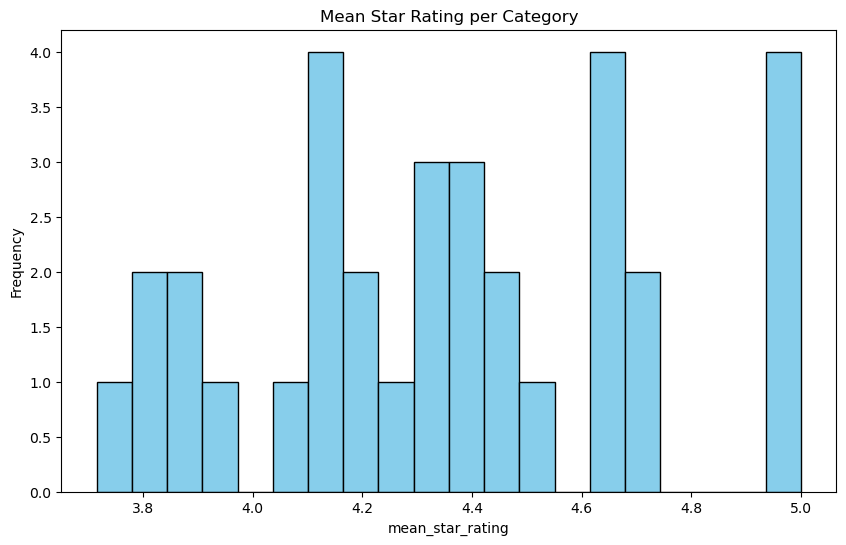

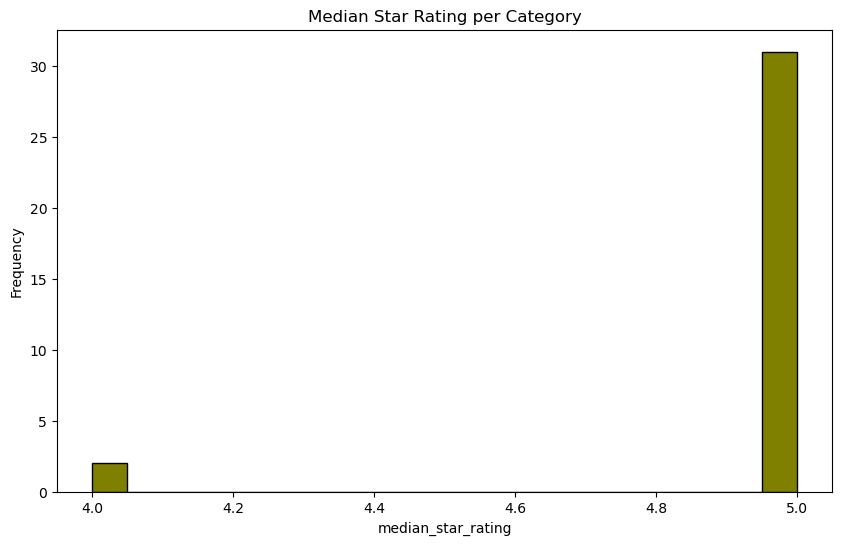

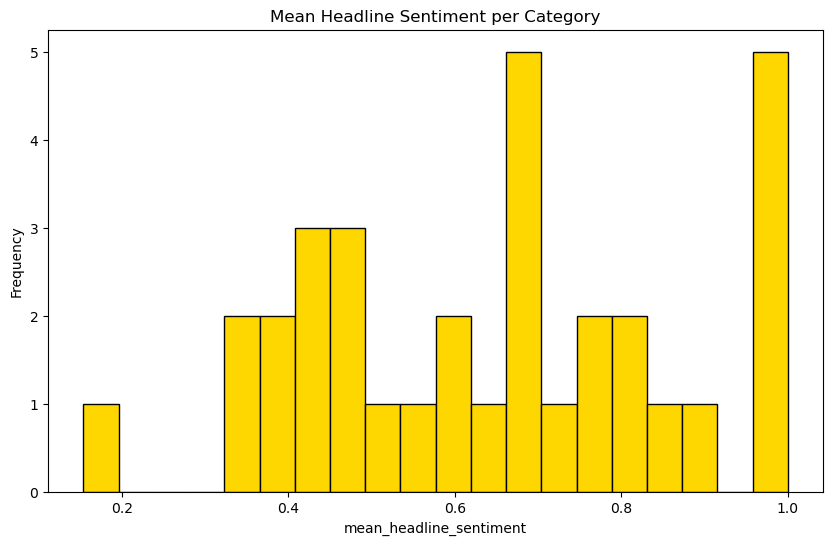

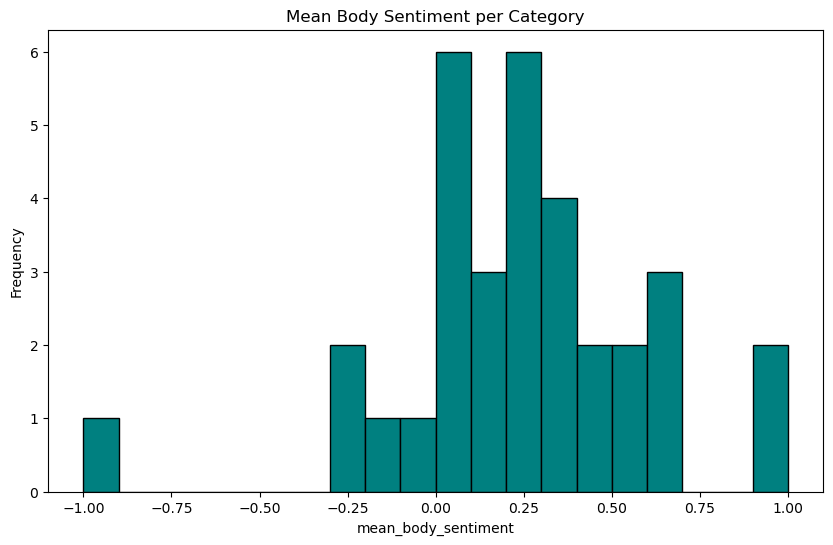

In [23]:
import matplotlib.pyplot as plt


def plot_histogram(data, column, title, color):
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=20, color=color, edgecolor="black")
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()


plot_histogram(stats_pd, "mean_star_rating", "Mean Star Rating per Category", "skyblue")
plot_histogram(
    stats_pd, "median_star_rating", "Median Star Rating per Category", "olive"
)
plot_histogram(
    stats_pd, "mean_headline_sentiment", "Mean Headline Sentiment per Category", "gold"
)
plot_histogram(
    stats_pd, "mean_body_sentiment", "Mean Body Sentiment per Category", "teal"
)

In [24]:
review_bodies = sampled_df.select("review_body").rdd.flatMap(lambda x: x).collect()
text = " ".join(review_bodies)

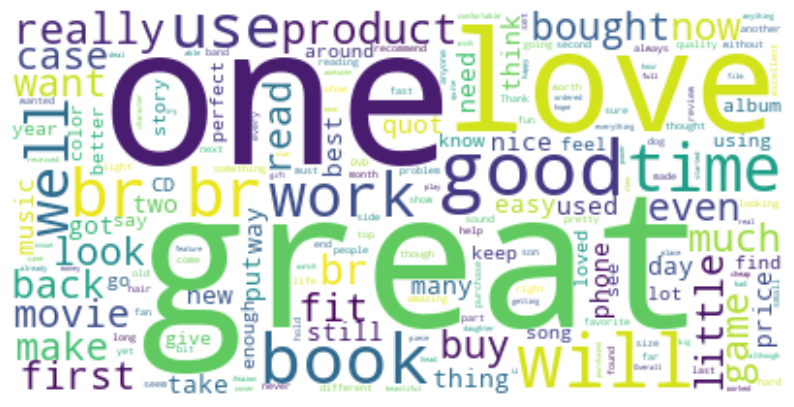

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()